In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='microsoft/deberta-base'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'rank, alpha':[]}

In [4]:
g = 4
lr = 1.0e-5
wd = 0.0
alphas = [8, 16]
ranks = [8, 16]
lora_dropout = 0.0


for a,r in zip(alphas, ranks):
    print(f'Grid search {model_checkpoint}, learning rate {lr} focal loss, gamma: {g} wd: {wd}, Lora alpha {a}, rank {r}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,
                            num_labels=data.num_labels,
                            lora=True,
                            r=r,
                            alpha=a,
                            dropout=lora_dropout)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                          wd=wd,
                          train_dataloader=data.train_dataloader,
                          eval_dataloader=data.eval_dataloader,
                          test_dataloader=data.test_dataloader,
                          focalloss=True,
                          gamma=g,
                          early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['rank, alpha'].append(r)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search microsoft/deberta-base, learning rate 1e-05 focal loss, gamma: 4 wd: 0.0, Lora alpha 8, rank 8


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0870	Val Loss:	0.6944	Accuracy:	0.2670	F1:	0.2165
2 / 30: Train Loss:	0.0871	Val Loss:	0.6936	Accuracy:	0.3414	F1:	0.3313
3 / 30: Train Loss:	0.0874	Val Loss:	0.6934	Accuracy:	0.3786	F1:	0.3760
4 / 30: Train Loss:	0.0872	Val Loss:	0.6934	Accuracy:	0.3982	F1:	0.3971
5 / 30: Train Loss:	0.0863	Val Loss:	0.6934	Accuracy:	0.3851	F1:	0.3821
6 / 30: Train Loss:	0.0869	Val Loss:	0.6934	Accuracy:	0.3961	F1:	0.3942
7 / 30: Train Loss:	0.0868	Val Loss:	0.6937	Accuracy:	0.3217	F1:	0.3039
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.28      0.85      0.42       119
      struct       0.82      0.24      0.37       338

    accuracy                           0.40       457
   macro avg       0.55      0.54      0.40       457
weighted avg       0.68      0.40      0.38       457

test results:
              precision    recall  f1-score   support

       bknow

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0869	Val Loss:	0.6944	Accuracy:	0.2670	F1:	0.2165
2 / 30: Train Loss:	0.0871	Val Loss:	0.6936	Accuracy:	0.3501	F1:	0.3409
3 / 30: Train Loss:	0.0874	Val Loss:	0.6934	Accuracy:	0.3939	F1:	0.3925
4 / 30: Train Loss:	0.0872	Val Loss:	0.6934	Accuracy:	0.4136	F1:	0.4132
5 / 30: Train Loss:	0.0863	Val Loss:	0.6934	Accuracy:	0.4136	F1:	0.4129
6 / 30: Train Loss:	0.0869	Val Loss:	0.6933	Accuracy:	0.4311	F1:	0.4310
7 / 30: Train Loss:	0.0868	Val Loss:	0.6935	Accuracy:	0.3786	F1:	0.3725
8 / 30: Train Loss:	0.0872	Val Loss:	0.6937	Accuracy:	0.3611	F1:	0.3502
9 / 30: Train Loss:	0.0867	Val Loss:	0.6935	Accuracy:	0.4136	F1:	0.4118
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.29      0.85      0.44       119
      struct       0.84      0.28      0.42       338

    accuracy                           0.43       457
   macro avg       0.57      0.57      0.43   

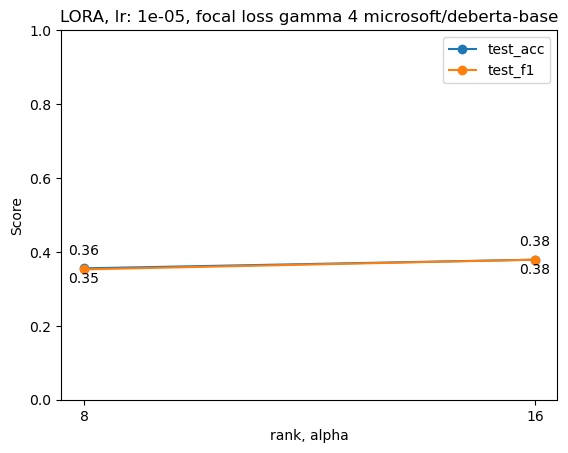

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'LORA, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='rank, alpha',
                        sci_format=False)

In [6]:
%reset -f